# Image Classification on CIFAR-10 with a Simple CNN
I made use of the [TinyVGG](https://github.com/poloclub/cnn-explainer/blob/master/tiny-vgg/tiny-vgg.py) architecture
to perform classification on CIFAR-10. Achieved an accuracy of around 75%

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}\ndevice: {device}")


PyTorch version: 2.4.0
torchvision version: 0.19.0
device: cuda


## Importing and viewing the data

In [2]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

len(train_data.data), len(test_data.data)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

Text(0.5, 1.0, 'frog')

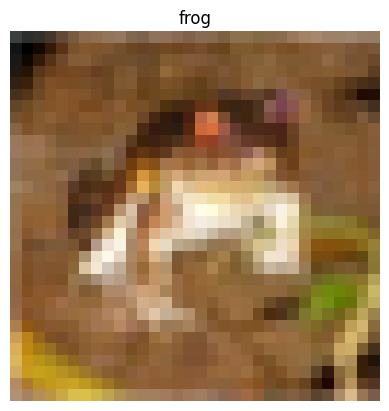

In [3]:
# Viewing a specific image
image, label = train_data[0]
plt.imshow(image.permute(1,2,0))
plt.axis(False);
plt.title(train_data.classes[label])

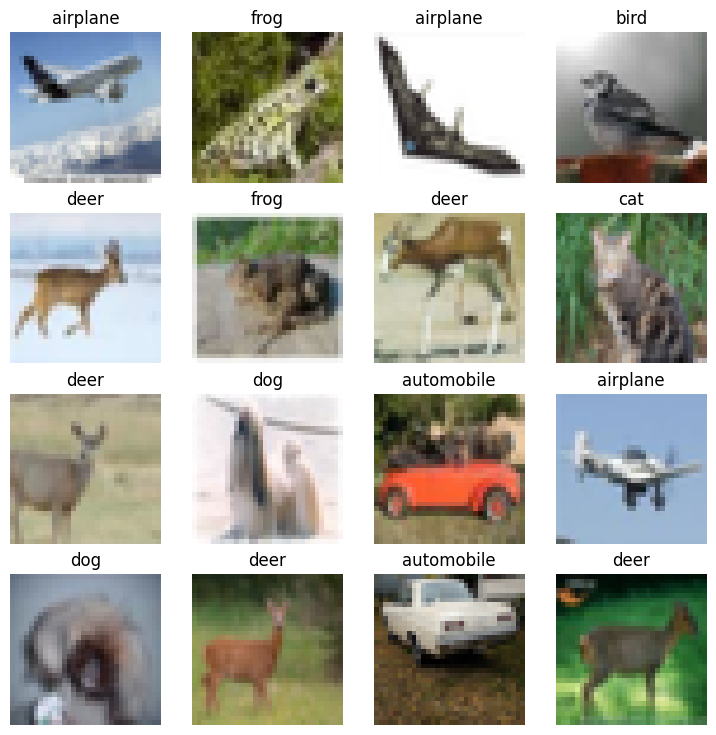

In [4]:
# Viewing a random set of images
class_names = train_data.classes
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1,2,0).squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## Setting up data loaders and timer

In [5]:
from torch.utils.data import DataLoader
batch_size = 32

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train dataloader: {len(train_dataloader)} batches of size {batch_size}")
print(f"Test dataloader: {len(test_dataloader)} batches of size {batch_size}")

Train dataloader: 1563 batches of size 32
Test dataloader: 313 batches of size 32


In [6]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

def print_train_time(start: float, end: float, device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

## Setting up the model, loss function etc.

In [7]:
# Defining the CNN - I'm using the TinyVGG architecture with 250 hidden units

class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8, out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
            x = self.block_1(x)
            x = self.block_2(x)
            x = self.classifier(x)
            return x

In [8]:
#Instantiating the model

model = TinyVGG(input_shape=3, hidden_units=250, output_shape=len(class_names))

In [9]:
#Defining optimizer, accuracy, and loss function

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()
def accuracy_fn(pred, true):
    return 100*sum(pred == true) / len(true)

## Creating functions for the training and testing steps

In [10]:
def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device = device):
    global train_acc #These are globals so I can plot them later
    global train_loss
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    size = len(data_loader)
    
    for batch, (X, y) in enumerate(data_loader):     
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss/size
        train_acc += accuracy_fn(true=y, pred=y_pred.argmax(dim=1))/size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [11]:
def test_step(data_loader: torch.utils.data.DataLoader, model: torch.nn.Module, loss_fn: torch.nn.Module, accuracy_fn, device: torch.device = device):
    global test_acc #These are globals so I can plot them later
    global test_loss
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    size = len(data_loader)
    
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)/size
            test_acc += accuracy_fn(true=y, pred=test_pred.argmax(dim=1))/size

    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

## Training

In [12]:
train_time_start_on_gpu = timer()
epochs = 7
train_accs = []
test_accs = []
train_losses = []
test_losses = []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}\n----------")
    
    train_step(data_loader=train_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)
    test_step(data_loader=test_dataloader, model=model, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
    
    train_accs.append(train_acc.item())
    train_losses.append(train_loss.item())
    test_accs.append(test_acc.item())
    test_losses.append(test_loss.item())
    
train_time_end_on_gpu = timer()
total_train_time = print_train_time(start=train_time_start_on_gpu, end=train_time_end_on_gpu, device=device)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1
----------
Train loss: 1.63938 | Train accuracy: 40.95%
Test loss: 1.36490 | Test accuracy: 50.92%

Epoch: 2
----------
Train loss: 1.02582 | Train accuracy: 64.15%
Test loss: 0.95694 | Test accuracy: 66.40%

Epoch: 3
----------
Train loss: 0.77949 | Train accuracy: 73.13%
Test loss: 0.79959 | Test accuracy: 72.85%

Epoch: 4
----------
Train loss: 0.61756 | Train accuracy: 78.65%
Test loss: 0.75290 | Test accuracy: 75.01%

Epoch: 5
----------
Train loss: 0.49217 | Train accuracy: 82.84%
Test loss: 0.77366 | Test accuracy: 75.10%

Epoch: 6
----------
Train loss: 0.38007 | Train accuracy: 86.84%
Test loss: 0.80546 | Test accuracy: 74.44%

Epoch: 7
----------
Train loss: 0.29293 | Train accuracy: 89.71%
Test loss: 0.83856 | Test accuracy: 76.13%

Train time on cuda: 247.563 seconds


## Visualising the results
You can clearly see beyond 3-4 epochs that the model starts overfitting with minimal improvements to the testing data accuracy. The accuracy peaks around 75%

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

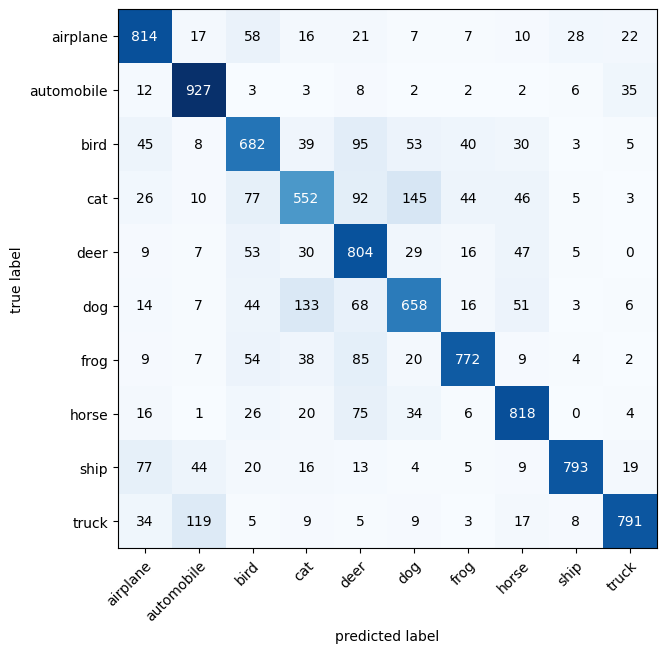

In [13]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#Making predictions on the testing data
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=torch.tensor(test_data.targets))

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=class_names, figsize=(10,7));

Text(0.5, 0, 'Epochs')

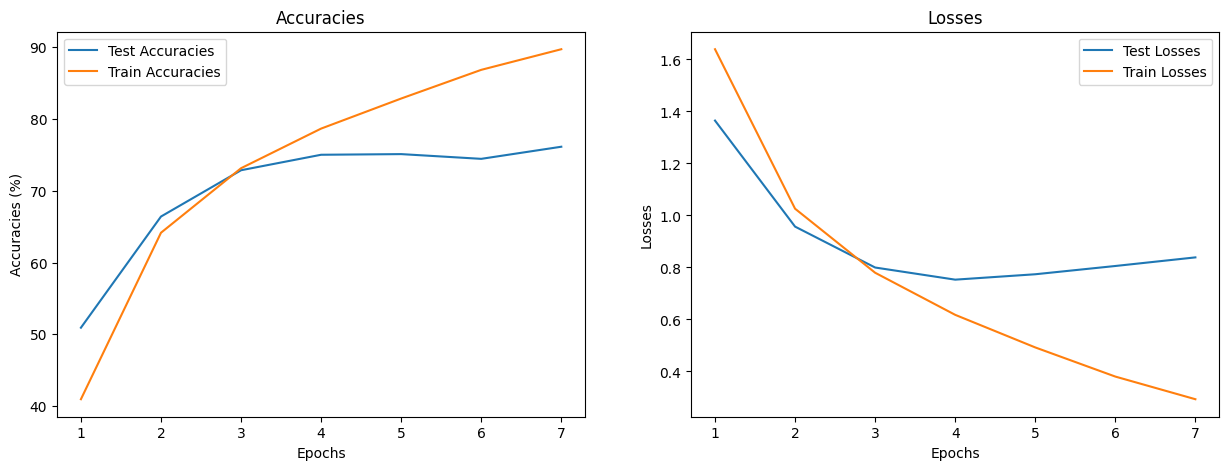

In [14]:
import numpy as np

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(15, 5)

ax1.plot(np.arange(1,epochs+1,1),test_accs, label="Test Accuracies")
ax1.plot(np.arange(1,epochs+1,1),train_accs, label="Train Accuracies")
ax1.set_title("Accuracies")
ax1.legend()
ax1.set_ylabel("Accuracies (%)")
ax1.set_xlabel("Epochs")

ax2.plot(np.arange(1,epochs+1,1),test_losses, label="Test Losses")
ax2.plot(np.arange(1,epochs+1,1),train_losses, label="Train Losses")
ax2.set_title("Losses")
ax2.legend()
ax2.set_ylabel("Losses")
ax2.set_xlabel("Epochs")